
# Audience Classification for Contextual Targeting


In [ ]:

# If running locally, ensure these are installed:
# pip install pandas numpy scikit-learn matplotlib tensorflow==2.*

import os, gc
import re
import math
import time
import json
import random
import pathlib
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(tf.__version__)


2.20.0


In [28]:


# { "category", "headline", "short_description", "authors", "date", "link" }
DATA_PATH = "News_Category_Dataset_v3.json"
df = pd.read_json(DATA_PATH, lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
df.dtypes

link                         object
headline                     object
category                     object
short_description            object
authors                      object
date                 datetime64[ns]
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
df.describe()

,date
count,209527
mean,2015-04-30 00:44:14.344308736
min,2012-01-28 00:00:00
25%,2013-08-10 00:00:00
50%,2015-03-16 00:00:00
75%,2016-11-01 00:00:00
max,2022-09-23 00:00:00


In [ ]:
df['authors']

0         Carla K. Johnson, AP
1               Mary Papenfuss
2                Elyse Wanshel
3             Caroline Bologna
4               Nina Golgowski
                  ...         
209522        Reuters, Reuters
209523                        
209524                        
209525                        
209526                        
Name: authors, Length: 209527, dtype: object

In [ ]:
# Combine headline and short_description into a single text column for modeling
df['headline'] = df['headline'].fillna('').astype(str)
df['short_description'] = df['short_description'].fillna('').astype(str)
df['text'] = (df['headline'] + ' ' + df['short_description']).str.strip()

# Remove redundant columns after feature engineering
df = df.drop(['headline', 'short_description', 'authors'], axis=1)
df.head()

,link,headline,category,short_description,authors,date,text
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...


In [34]:
# Create a list of authors for each article; handle missing or unknown values
def authors_to_list(x):
    if pd.isna(x) or str(x).strip() == '' or str(x).strip().lower() == 'unknown':
        return ['unknown']
    out = [a.strip() for a in str(x).split(',') if a.strip()]
    return out if out else ['unknown']

df['authors_list'] = df['authors'].apply(authors_to_list)
df.head(10)

,link,headline,category,short_description,authors,date,text,authors_list
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[Carla K. Johnson, AP]"
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",[Mary Papenfuss]
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,[Elyse Wanshel]
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,[Caroline Bologna]
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,[Nina Golgowski]
5,https://www.huffpost.com/entry/belk-worker-fou...,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...,,2022-09-22,Cleaner Was Dead In Belk Bathroom For 4 Days B...,[unknown]
6,https://www.huffpost.com/entry/reporter-gets-a...,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor...",Elyse Wanshel,2022-09-22,Reporter Gets Adorable Surprise From Her Boyfr...,[Elyse Wanshel]
7,https://www.huffpost.com/entry/puerto-rico-wat...,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,"DÁNICA COTO, AP",2022-09-22,Puerto Ricans Desperate For Water After Hurric...,"[DÁNICA COTO, AP]"
8,https://www.huffpost.com/entry/mija-documentar...,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus...",Marina Fang,2022-09-22,How A New Documentary Captures The Complexity ...,[Marina Fang]
9,https://www.huffpost.com/entry/biden-un-russia...,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,"Aamer Madhani, AP",2022-09-21,Biden At UN To Call Russian War An Affront To ...,"[Aamer Madhani, AP]"


In [35]:
# Deleting the columns we no longer need

df = df.drop(['headline', 'short_description', 'authors'], axis=1)
df.head()

,link,category,date,text,authors_list
0,https://www.huffpost.com/entry/covid-boosters-...,U.S. NEWS,2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[Carla K. Johnson, AP]"
1,https://www.huffpost.com/entry/american-airlin...,U.S. NEWS,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",[Mary Papenfuss]
2,https://www.huffpost.com/entry/funniest-tweets...,COMEDY,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,[Elyse Wanshel]
3,https://www.huffpost.com/entry/funniest-parent...,PARENTING,2022-09-23,The Funniest Tweets From Parents This Week (Se...,[Caroline Bologna]
4,https://www.huffpost.com/entry/amy-cooper-lose...,U.S. NEWS,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,[Nina Golgowski]


## Feature Engineering and Data Cleaning
- Combined `headline` and `short_description` into a single `text` column for modeling.
- Created `authors_list` to standardize author information and handle missing values.
- Removed redundant columns to keep the dataset clean and focused for downstream tasks.

In [36]:
df['category'].unique(), df['category'].nunique()

(array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
        'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
        'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
        'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
        'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
        'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
        'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
        'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
        'FIFTY', 'ARTS', 'DIVORCE'], dtype=object),
 42)

#### Category Anomalies & Normalization

The raw HuffPost dataset contains **duplicate or inconsistent categories**, e.g.:
- `"THE WORLDPOST"` vs `"WORLDPOST"`
- `"ARTS & CULTURE"` vs `"CULTURE & ARTS"`
- `"STYLE"` vs `"STYLE & BEAUTY"`
- `"GREEN"` vs `"ENVIRONMENT"`
- `"HEALTHY LIVING"` vs `"WELLNESS"`

It also includes some **section-specific or channel labels** (e.g. `"FIFTY"`, `"IMPACT"`, `"BLACK VOICES"`, `"QUEER VOICES"`, `"LATINO VOICES"`) that do not align cleanly to IAB taxonomy.  
We normalize these categories into broader consistent labels before mapping to IAB taxonomy to avoid fragmentation and improve downstream classification.


In [45]:
#  Category Normalization Map 
CATEGORY_NORMALIZATION = {
    # Merge duplicate/variant labels
    "THE WORLDPOST": "WORLDPOST",
    "ARTS & CULTURE": "CULTURE & ARTS",
    "STYLE": "STYLE & BEAUTY",
    "GREEN": "ENVIRONMENT",
    "HEALTHY LIVING": "WELLNESS",
    
    # Media/company-specific → broader buckets
    "IMPACT": "SOCIETY",       
    "FIFTY": "STYLE & BEAUTY",    
    "WOMEN": "STYLE & BEAUTY",    
    "BLACK VOICES": "SOCIETY",
    "QUEER VOICES": "SOCIETY",
    "LATINO VOICES": "SOCIETY",
    "GOOD NEWS": "WORLD NEWS",    
    "MEDIA": "ENTERTAINMENT",    
    
    # Keep these as is (already aligned enough)
    # 'U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'TECH',
    # 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
    # 'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'BUSINESS',
    # 'FOOD & DRINK', 'HOME & LIVING', 'TRAVEL', 'MONEY', 'RELIGION',
    # 'WEDDINGS', 'COLLEGE', 'PARENTS', 'TASTE', 'ARTS', 'DIVORCE'
}

# Apply normalization
df['category'] = df['category'].replace(CATEGORY_NORMALIZATION)


In [41]:

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
df.sample(3, random_state=RANDOM_SEED)


Shape: (209527, 6)

Columns: ['link', 'category', 'date', 'text', 'authors_list', 'category_norm']


,link,category,date,text,authors_list,category_norm
128310,https://www.huffingtonpost.com/entry/what-if-w...,IMPACT,2014-06-20,What If We Were All Family Generation Changers...,"[Matt Murrie, ContributorEdupreneur, Cofounder...",SOCIETY
139983,https://www.huffingtonpost.comhttp://www.washi...,BUSINESS,2014-02-08,Firestorm At AOL Over Employee Benefit Cuts It...,[unknown],BUSINESS
42339,https://www.huffingtonpost.com/entry/time-runs...,POLITICS,2017-02-22,Dakota Access Protesters Arrested As Deadline ...,"[Michael McLaughlin & Josh Morgan, The Huffing...",POLITICS


category
POLITICS          35602
WELLNESS          24639
ENTERTAINMENT     20306
STYLE & BEAUTY    17041
SOCIETY           15544
TRAVEL             9900
PARENTING          8791
FOOD & DRINK       6340
WORLDPOST          6243
BUSINESS           5992
COMEDY             5400
SPORTS             5077
WORLD NEWS         4697
HOME & LIVING      4320
ENVIRONMENT        4066
PARENTS            3955
WEDDINGS           3653
CRIME              3562
DIVORCE            3426
WEIRD NEWS         2777
Name: count, dtype: int64


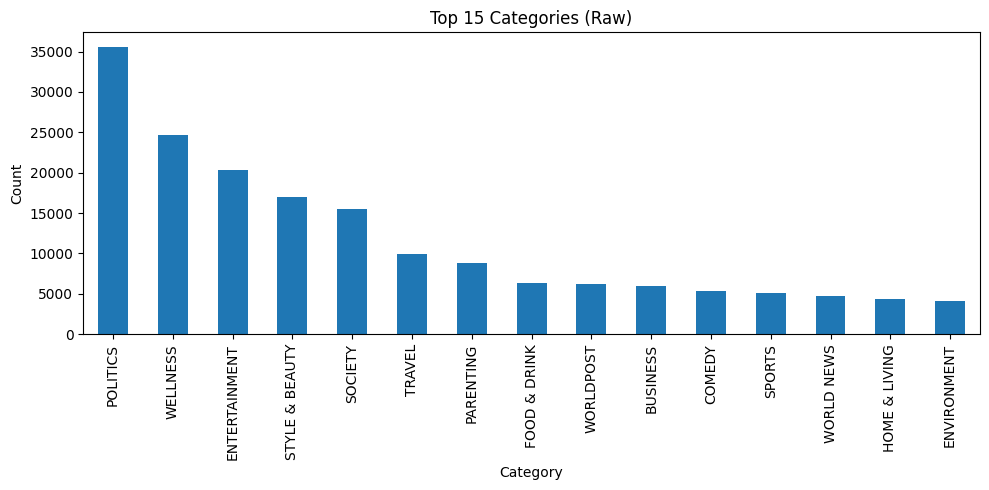

In [47]:

cat_counts = df['category'].value_counts().sort_values(ascending=False)
print(cat_counts.head(20))

plt.figure(figsize=(10, 5))
cat_counts.head(15).plot(kind='bar')
plt.title("Top 15 Categories (Raw)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [49]:
df['category'].unique(), df['category'].nunique()

(array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
        'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
        'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
        'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'SOCIETY',
        'HOME & LIVING', 'TRAVEL', 'MONEY', 'RELIGION', 'WEDDINGS',
        'COLLEGE', 'PARENTS', 'TASTE', 'WORLDPOST', 'ARTS', 'DIVORCE'],
       dtype=object),
 30)


### Mapping Dataset Categories → IAB Content Taxonomy (Stub)



In [50]:

IAB_MAP = {
    # --- News & Politics ---
    "U.S. NEWS":        "IAB2-1_Hard_News",
    "WORLD NEWS":       "IAB2-1_Hard_News",
    "WORLDPOST":        "IAB2-1_Hard_News",
    "POLITICS":         "IAB2-3_Politics",
    "CRIME":            "IAB2-6_Crime",
    "WEIRD NEWS":       "IAB2-7_Weird_News",
    
    # --- Arts, Culture & Entertainment ---
    "ENTERTAINMENT":    "IAB1_Arts_Entertainment",
    "COMEDY":           "IAB1-6_Comedy",
    "CULTURE & ARTS":   "IAB1-1_Culture_Arts",
    "ARTS":             "IAB1-1_Culture_Arts",
    "STYLE & BEAUTY":   "IAB18-3_Fashion_Beauty",
    
    # --- Lifestyle & Society ---
    "SOCIETY":          "IAB19_Society",
    "DIVORCE":          "IAB19-7_Family_Relationships",
    "WEDDINGS":         "IAB19-7_Family_Relationships",
    "PARENTS":          "IAB19-7_Family_Relationships",
    "PARENTING":        "IAB19-7_Family_Relationships",
    "HOME & LIVING":    "IAB19-1_Home_Garden",
    "TRAVEL":           "IAB20_Travel",
    "TASTE":            "IAB8-5_Food_Drinks",   # HuffPost "Taste" = food blog
    
    # --- Health, Wellness, Education ---
    "WELLNESS":         "IAB7-1_Health_Wellness",
    "EDUCATION":        "IAB5_Education",
    
    # --- Business & Finance ---
    "BUSINESS":         "IAB3_Business",
    "MONEY":            "IAB13_Personal_Finance",
    
    # --- Science & Technology ---
    "TECH":             "IAB19-9_Technology_Internet",
    "SCIENCE":          "IAB15_Science",
    
    # --- Food & Drink ---
    "FOOD & DRINK":     "IAB8_Food_Drinks",
    
    # --- Environment ---
    "ENVIRONMENT":      "IAB14_Green_Living",
    
    # --- College (special case) ---
    "COLLEGE":          "IAB5-2_Education_Colleges"
}


df['iab_label'] = df['category'].map(IAB_MAP).fillna(df['category'])
label_col = 'iab_label'  # choose which to train on: 'iab_label' or original 'category'
print(df[[ 'category', 'iab_label']].head(10))


         category                     iab_label
0       U.S. NEWS              IAB2-1_Hard_News
1       U.S. NEWS              IAB2-1_Hard_News
2          COMEDY                 IAB1-6_Comedy
3       PARENTING  IAB19-7_Family_Relationships
4       U.S. NEWS              IAB2-1_Hard_News
5       U.S. NEWS              IAB2-1_Hard_News
6       U.S. NEWS              IAB2-1_Hard_News
7      WORLD NEWS              IAB2-1_Hard_News
8  CULTURE & ARTS           IAB1-1_Culture_Arts
9      WORLD NEWS              IAB2-1_Hard_News


In [54]:
df['iab_label'].unique(), df['iab_label'].nunique()

(array(['IAB2-1_Hard_News', 'IAB1-6_Comedy',
        'IAB19-7_Family_Relationships', 'IAB1-1_Culture_Arts',
        'IAB19-9_Technology_Internet', 'SPORTS', 'IAB1_Arts_Entertainment',
        'IAB2-3_Politics', 'IAB2-7_Weird_News', 'IAB14_Green_Living',
        'IAB5_Education', 'IAB2-6_Crime', 'IAB15_Science',
        'IAB7-1_Health_Wellness', 'IAB3_Business',
        'IAB18-3_Fashion_Beauty', 'IAB8_Food_Drinks', 'IAB19_Society',
        'IAB19-1_Home_Garden', 'IAB20_Travel', 'IAB13_Personal_Finance',
        'RELIGION', 'IAB5-2_Education_Colleges', 'IAB8-5_Food_Drinks'],
       dtype=object),
 24)

In [52]:
df.head()

,link,category,date,text,authors_list,iab_label
0,https://www.huffpost.com/entry/covid-boosters-...,U.S. NEWS,2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[Carla K. Johnson, AP]",IAB2-1_Hard_News
1,https://www.huffpost.com/entry/american-airlin...,U.S. NEWS,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",[Mary Papenfuss],IAB2-1_Hard_News
2,https://www.huffpost.com/entry/funniest-tweets...,COMEDY,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,[Elyse Wanshel],IAB1-6_Comedy
3,https://www.huffpost.com/entry/funniest-parent...,PARENTING,2022-09-23,The Funniest Tweets From Parents This Week (Se...,[Caroline Bologna],IAB19-7_Family_Relationships
4,https://www.huffpost.com/entry/amy-cooper-lose...,U.S. NEWS,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,[Nina Golgowski],IAB2-1_Hard_News


In [57]:
df.shape

(209527, 6)

In [62]:

# Filter very short texts
df = df[df['text'].str.len() > 5].copy()

# Keep top N labels
TOP_N = 20
top_labels = df[label_col].value_counts().head(TOP_N).index.tolist()
top_labels
df = df[df[label_col].isin(top_labels)].copy()
print("Shape after filtering:", df.shape)


Shape after filtering: (203500, 6)


In [63]:
# Encode labels
label_to_id = {label:i for i, label in enumerate(sorted(df[label_col].unique()))}
id_to_label = {i:l for l, i in label_to_id.items()}
df['label_id'] = df[label_col].map(label_to_id)

X_train, X_temp, y_train, y_temp = train_test_split(
    df.index, df['label_id'], test_size=0.2, stratify=df['label_id'], random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp.loc[X_temp], test_size=0.5, stratify=y_temp.loc[X_temp], random_state=RANDOM_SEED
)

train_df = df.loc[X_train]
val_df = df.loc[X_val]
test_df = df.loc[X_test]

len(train_df), len(val_df), len(test_df), len(label_to_id)

(162800, 20350, 20350, 20)

In [64]:
df.head()

,link,category,date,text,authors_list,iab_label,label_id
0,https://www.huffpost.com/entry/covid-boosters-...,U.S. NEWS,2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[Carla K. Johnson, AP]",IAB2-1_Hard_News,10
1,https://www.huffpost.com/entry/american-airlin...,U.S. NEWS,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",[Mary Papenfuss],IAB2-1_Hard_News,10
2,https://www.huffpost.com/entry/funniest-tweets...,COMEDY,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,[Elyse Wanshel],IAB1-6_Comedy,1
3,https://www.huffpost.com/entry/funniest-parent...,PARENTING,2022-09-23,The Funniest Tweets From Parents This Week (Se...,[Caroline Bologna],IAB19-7_Family_Relationships,6
4,https://www.huffpost.com/entry/amy-cooper-lose...,U.S. NEWS,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,[Nina Golgowski],IAB2-1_Hard_News,10



## Baseline Model: TF‑IDF + Logistic Regression

Gives a fast baseline and a precision target to compare against CNN.


Baseline Accuracy (val): 0.6853071253071253
Baseline Macro Precision (val): 0.6921701510902749

Test Set Report:
                              precision    recall  f1-score   support

         IAB1-1_Culture_Arts       0.66      0.36      0.46       392
               IAB1-6_Comedy       0.66      0.36      0.47       540
          IAB14_Green_Living       0.57      0.37      0.45       406
               IAB15_Science       0.79      0.35      0.48       220
      IAB18-3_Fashion_Beauty       0.69      0.66      0.68      1704
         IAB19-1_Home_Garden       0.88      0.64      0.74       432
IAB19-7_Family_Relationships       0.70      0.79      0.74      1983
 IAB19-9_Technology_Internet       0.69      0.30      0.42       211
               IAB19_Society       0.60      0.51      0.55      1554
     IAB1_Arts_Entertainment       0.61      0.73      0.66      2031
            IAB2-1_Hard_News       0.64      0.57      0.60      1231
             IAB2-3_Politics       0.72      0

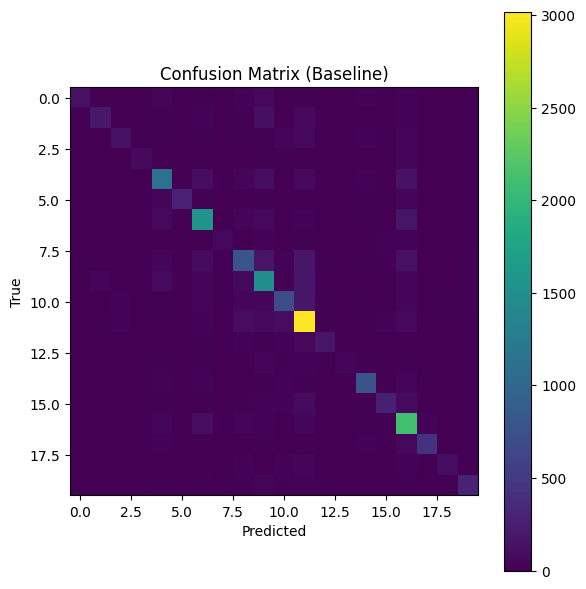

In [69]:

# TF-IDF on text
tfidf = TfidfVectorizer(max_features=100_000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(train_df['text'])
Xv = tfidf.transform(val_df['text'])
Xte = tfidf.transform(test_df['text'])

clf = LogisticRegression(max_iter=400, n_jobs=None, verbose=0)
clf.fit(Xtr, train_df['label_id'])

pred_val = clf.predict(Xv)
pred_test = clf.predict(Xte)

print("Baseline Accuracy (val):", accuracy_score(val_df['label_id'], pred_val))
print("Baseline Macro Precision (val):", precision_score(val_df['label_id'], pred_val, average='macro'))

print("\nTest Set Report:")
print(classification_report(test_df['label_id'], pred_test, target_names=[id_to_label[i] for i in range(len(id_to_label))]))

cm = confusion_matrix(test_df['label_id'], pred_test)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


<Axes: xlabel='label_id'>

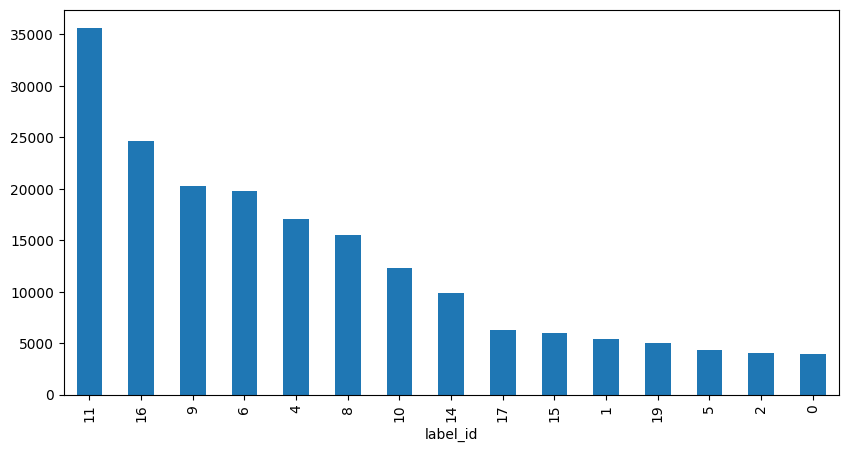

In [67]:
cat_counts = df['label_id'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
cat_counts.head(15).plot(kind='bar')

The plot and confusion matrix indicate that the model achieved high accuracy when predicting articles belonging to the classes with the largest number of examples like 11 and 16 in our case.


## Keras 1D‑CNN Text Classifier


In [115]:
# 1) Train/Val/Test split (stratified on label_id)

y_all = df['label_id'].astype(int).values
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=y_all)
y_temp = temp_df['label_id'].astype(int).values
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=y_temp)

num_classes = int(df['label_id'].nunique())
print(f"Splits -> train={len(train_df)} val={len(val_df)} test={len(test_df)} | classes={num_classes}")


# 2) Text → sequences

MAX_VOCAB = 60_000
MAX_LEN   = 256

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'].tolist())

def to_seq(texts):
    seqs = tokenizer.texts_to_sequences(texts.tolist())
    return pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

Xtr_seq = to_seq(train_df['text'])
Xv_seq  = to_seq(val_df['text'])
Xte_seq = to_seq(test_df['text'])

Splits -> train=162800 val=20350 test=20350 | classes=20


In [120]:
# 3) Authors → hashed IDs (multi-author, padded) with PAD=0
AUTHOR_BUCKETS = 20_001   # reserve 0 for PAD
MAX_AUTHORS    = 3        # consider first 3 authors; adjust if needed

import hashlib

import pandas as pd

def hash_author(name: str, n_buckets=AUTHOR_BUCKETS):
    if not name or not isinstance(name, str): 
        return 0
    h = int(hashlib.md5(name.strip().lower().encode('utf-8')).hexdigest(), 16)
    return 1 + (h % (n_buckets - 1))  # [1..n_buckets-1]

def encode_authors(series, max_authors=MAX_AUTHORS, n_buckets=AUTHOR_BUCKETS):
    rows = []
    for names in series:
        ids = [hash_author(n) for n in (names or [])][:max_authors]
        if len(ids) < max_authors:
            ids = ids + [0] * (max_authors - len(ids))
        rows.append(ids)
    return np.array(rows, dtype='int32')

Xtr_auth = encode_authors(train_df['authors_list'])
Xv_auth  = encode_authors(val_df['authors_list'])
Xte_auth = encode_authors(test_df['authors_list'])

# 4) Numeric metadata: year, month, weekday, text_len, n_authors
def build_meta(frame: pd.DataFrame):
    f = frame.copy()
    f['date_parsed'] = pd.to_datetime(f['date'], errors='coerce', utc=True)
    f['year']    = f['date_parsed'].dt.year.fillna(-1).astype(int)
    f['month']   = f['date_parsed'].dt.month.fillna(-1).astype(int)
    f['weekday'] = f['date_parsed'].dt.weekday.fillna(-1).astype(int)
    f['text_len'] = f['text'].str.split().apply(len).astype(int)
    f['n_authors'] = f['authors_list'].apply(lambda xs: len(xs) if isinstance(xs, list) else 0).astype(int)
    return f[['year','month','weekday','text_len','n_authors']].astype(float)

meta_cols = ['year','month','weekday','text_len','n_authors']
Xtr_meta = build_meta(train_df)
Xv_meta  = build_meta(val_df)
Xte_meta = build_meta(test_df)

scaler = StandardScaler().fit(Xtr_meta.values)
Xtr_meta = scaler.transform(Xtr_meta.values).astype('float32')
Xv_meta  = scaler.transform(Xv_meta.values).astype('float32')
Xte_meta = scaler.transform(Xte_meta.values).astype('float32')

# Labels
y_train = train_df['label_id'].astype('int32').values
y_val   = val_df['label_id'].astype('int32').values
y_test  = test_df['label_id'].astype('int32').values

In [ ]:
# 5) Build Model: Multi-kernel TextCNN + Author-avg + Numeric Meta

text_in = keras.Input(shape=(MAX_LEN,), dtype='int32', name="text_ids")
tok_emb = layers.Embedding(input_dim=MAX_VOCAB, output_dim=128, name="tok_emb")(text_in)

# Multi-kernel convs
c3 = layers.Conv1D(128, 3, padding='same', activation='relu')(tok_emb)
c4 = layers.Conv1D(128, 4, padding='same', activation='relu')(tok_emb)
c5 = layers.Conv1D(128, 5, padding='same', activation='relu')(tok_emb)
p3 = layers.GlobalMaxPool1D()(c3)
p4 = layers.GlobalMaxPool1D()(c4)
p5 = layers.GlobalMaxPool1D()(c5)
text_vec = layers.Concatenate()([p3, p4, p5])  # [B, 384]
text_vec = layers.Dropout(0.2)(text_vec)

# Author masked-average
auth_in  = keras.Input(shape=(MAX_AUTHORS,), dtype='int32', name="author_ids")
auth_emb = layers.Embedding(input_dim=AUTHOR_BUCKETS, output_dim=24, mask_zero=True, name="author_emb")(auth_in)
def masked_avg(args):
    emb, ids = args                       # emb: [B, A, 24], ids: [B, A]
    mask = tf.cast(tf.not_equal(ids, 0), tf.float32)   # 1 for real author, 0 for PAD
    mask = tf.expand_dims(mask, -1)                     # [B, A, 1]
    sum_vec = tf.reduce_sum(emb * mask, axis=1)         # [B, 24]
    cnt_vec = tf.reduce_sum(mask, axis=1)               # [B, 1]
    cnt_vec = tf.maximum(cnt_vec, 1.0)                  # avoid div-by-zero
    return sum_vec / cnt_vec
auth_vec = layers.Lambda(masked_avg, name="author_avg")([auth_emb, auth_in])  # [B, 24]
auth_vec = layers.Dropout(0.1)(auth_vec)

# Numeric meta branch
meta_in = keras.Input(shape=(Xtr_meta.shape[1],), dtype='float32', name='meta_in')
m = layers.Dense(32, activation='relu')(meta_in)
m = layers.Dropout(0.1)(m)

# Fusion
h = layers.Concatenate()([text_vec, auth_vec, m])
h = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(h)
h = layers.Dropout(0.3)(h)
out = layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=[text_in, auth_in, meta_in], outputs=out)

In [ ]:
# authors branch (masked average) 
AUTHOR_BUCKETS = 20001
auth_in  = keras.Input(shape=(MAX_AUTHORS,), dtype='int32', name="author_ids")
auth_emb = layers.Embedding(input_dim=AUTHOR_BUCKETS, output_dim=24, mask_zero=True, name="author_emb")(auth_in)

def masked_avg(args):
    emb, ids = args                       # emb: [B, A, 24], ids: [B, A]
    mask = tf.cast(tf.not_equal(ids, 0), tf.float32)
    mask = tf.expand_dims(mask, -1)       # [B, A, 1]
    sum_vec = tf.reduce_sum(emb * mask, axis=1)   # [B, 24]
    cnt_vec = tf.reduce_sum(mask, axis=1)         # [B, 1]
    cnt_vec = tf.maximum(cnt_vec, 1.0)
    return sum_vec / cnt_vec

auth_vec = layers.Lambda(masked_avg, name="author_avg")([auth_emb, auth_in])
auth_vec = layers.Dropout(0.1)(auth_vec)

# numeric meta branch
meta_in = keras.Input(shape=(Xtr_meta.shape[1],), dtype='float32', name='meta_in')
m = layers.Dense(48, activation='relu')(meta_in)
m = layers.Dropout(0.1)(m)

# fusion
h = layers.Concatenate()([text_vec, auth_vec, m])
h = layers.Dense(384, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(h)
h = layers.Dropout(FUSION_DROPOUT)(h)
out = layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=[text_in, auth_in, meta_in], outputs=out)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_ids            │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tok_emb (Embedding) │ (None, 256, 128)  │  7,680,000 │ text_ids[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 128)  │     49,280 │ tok_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 256, 128)  │     65,664 │ tok_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 256, 128)  │     82,048 │ tok_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_ids          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_emb          │ (None, 3, 24)     │    480,024 │ author_ids[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_in             │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_avg (Lambda) │ (None, 24)        │          0 │ author_emb[0][0], │
│                     │                   │            │ author_ids[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 48)        │        288 │ meta_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 384)       │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24)        │          0 │ author_avg[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 48)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 456)       │          0 │ dropout_14[0][0], │
│ (Concatenate)       │                   │            │ dropout_18[0][0]

 Total params: 8,540,492 (32.58 MB)

 Trainable params: 8,540,492 (32.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6) Training setup: Cosine LR + callbacks 

BATCH = 256
EPOCHS = 10

# tf.data pipelines (fast)
train_ds = tf.data.Dataset.from_tensor_slices(
    ({"text_ids": Xtr_seq, "author_ids": Xtr_auth, "meta_in": Xtr_meta}, y_train)
).shuffle(8192, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    ({"text_ids": Xv_seq, "author_ids": Xv_auth, "meta_in": Xv_meta}, y_val)
).batch(BATCH).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = int(np.ceil(len(Xtr_seq)/BATCH))
total_steps = steps_per_epoch * EPOCHS
lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=3e-4, decay_steps=total_steps)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

cbs = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
    
]

# Class weights (for imbalanced data)
USE_CLASS_WEIGHTS = False
class_weights = None
# if USE_CLASS_WEIGHTS:
#     classes = np.unique(y_train)
#     cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
#     class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
#     print("Class weights:", class_weights)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    class_weight=class_weights,
    verbose=2
)

Epoch 1/10
636/636 - 202s - 318ms/step - accuracy: 0.9004 - loss: 0.3447 - val_accuracy: 0.7855 - val_loss: 0.7663
Epoch 2/10
636/636 - 202s - 318ms/step - accuracy: 0.9004 - loss: 0.3447 - val_accuracy: 0.7855 - val_loss: 0.7663
Epoch 2/10
636/636 - 208s - 328ms/step - accuracy: 0.9321 - loss: 0.2432 - val_accuracy: 0.7820 - val_loss: 0.8328
Epoch 3/10
636/636 - 208s - 328ms/step - accuracy: 0.9321 - loss: 0.2432 - val_accuracy: 0.7820 - val_loss: 0.8328
Epoch 3/10
636/636 - 206s - 324ms/step - accuracy: 0.9571 - loss: 0.1646 - val_accuracy: 0.7771 - val_loss: 0.9158
636/636 - 206s - 324ms/step - accuracy: 0.9571 - loss: 0.1646 - val_accuracy: 0.7771 - val_loss: 0.9158


In [ ]:
# 7) Evaluate on test

test_ds = tf.data.Dataset.from_tensor_slices(
    ({"text_ids": Xte_seq, "author_ids": Xte_auth, "meta_in": Xte_meta}, y_test)
).batch(512)

probs = model.predict(test_ds, verbose=0)
pred  = probs.argmax(axis=1)

acc = accuracy_score(y_test, pred)
print(f"\nTest accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, pred, digits=3))


Test accuracy: 0.7831

Classification report:
              precision    recall  f1-score   support

           0      0.747     0.699     0.722       392
           1      0.685     0.654     0.669       540
           2      0.639     0.567     0.601       406
           3      0.721     0.505     0.594       220
           4      0.840     0.792     0.815      1704
           5      0.912     0.812     0.859       432
           6      0.843     0.853     0.848      1983
           7      0.736     0.517     0.607       211
           8      0.721     0.683     0.701      1554
           9      0.783     0.807     0.795      2031
          10      0.673     0.706     0.689      1231
          11      0.812     0.869     0.840      3560
          12      0.587     0.566     0.576       357
          13      0.547     0.462     0.501       277
          14      0.874     0.868     0.871       990
          15      0.649     0.619     0.634       599
          16      0.796     0.873 


## TensorFlow Lite Conversion & Latency Benchmark
We convert the trained CNN to **TFLite**, run a quick **accuracy sanity check**, and **measure latency**.


In [127]:

# Convert to TFLite (dynamic range quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

TFLITE_PATH = "cnn_fusion_iab.tflite"
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print("Saved:", TFLITE_PATH, "Size (KB):", os.path.getsize(TFLITE_PATH) / 1024)



INFO:tensorflow:Assets written to: C:\Users\prash\AppData\Local\Temp\tmpu6nl4r1h\assets


INFO:tensorflow:Assets written to: C:\Users\prash\AppData\Local\Temp\tmpu6nl4r1h\assets


Saved artifact at 'C:\Users\prash\AppData\Local\Temp\tmpu6nl4r1h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256), dtype=tf.int32, name='text_ids'), TensorSpec(shape=(None, 3), dtype=tf.int32, name='author_ids'), TensorSpec(shape=(None, 5), dtype=tf.float32, name='meta_in')]
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  1876916039248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875851454672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875851456608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875851447280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875851455552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875724652384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1876916030272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875851614288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1875852180144: Tensor

In [128]:
# Build interpreter and inspect inputs/outputs
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n-- TFLite inputs --")
for i, d in enumerate(input_details):
    print(i, d["name"], d["dtype"], d["shape"])
print("-- TFLite outputs --")
for i, d in enumerate(output_details):
    print(i, d["name"], d["dtype"], d["shape"])

# Helper: find input indices by substring
def find_idx(substr, required=False):
    for d in input_details:
        if substr in d["name"]:
            return d["index"]
    if required:
        raise ValueError(f"Input containing '{substr}' not found in TFLite model.")
    return None

idx_text = find_idx("text_ids", required=True)
idx_auth = find_idx("author",   required=True)   # matches 'author_ids' or 'author_id'
idx_meta = find_idx("meta_in",  required=False)  # optional

# Capture expected dtypes (TFLite may expect int32 for text/auth, float32 for meta)
dtype_text = next(d["dtype"] for d in input_details if d["index"] == idx_text)
dtype_auth = next(d["dtype"] for d in input_details if d["index"] == idx_auth)
dtype_meta = None
if idx_meta is not None:
    dtype_meta = next(d["dtype"] for d in input_details if d["index"] == idx_meta)

# Helper to get the rest of the input shape (except batch dim)
def input_shape_without_batch(idx):
    d = next(dd for dd in input_details if dd["index"] == idx)
    return list(d["shape"])[1:]  # everything after batch dim

# 3) Batched TFLite prediction (works for 2- or 3-input model)
def tflite_predict_batch(text_ids, auth_ids, meta_arr=None):
    N = len(text_ids)
    text_arr = np.asarray(text_ids).astype(dtype_text)
    auth_arr = np.asarray(auth_ids).astype(dtype_auth)

    # Resize input tensors to batch N
    interpreter.resize_tensor_input(idx_text, [N] + input_shape_without_batch(idx_text))
    interpreter.resize_tensor_input(idx_auth, [N] + input_shape_without_batch(idx_auth))
    if idx_meta is not None:
        if meta_arr is None:
            raise ValueError("This TFLite model expects 'meta_in' but meta_arr=None was provided.")
        meta_arr = np.asarray(meta_arr).astype(dtype_meta)
        interpreter.resize_tensor_input(idx_meta, [N] + input_shape_without_batch(idx_meta))

    interpreter.allocate_tensors()

    # Set tensors
    interpreter.set_tensor(idx_text, text_arr)
    interpreter.set_tensor(idx_auth, auth_arr)
    if idx_meta is not None:
        interpreter.set_tensor(idx_meta, meta_arr)

    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]["index"])
    return out


-- TFLite inputs --
0 serving_default_meta_in:0 <class 'numpy.float32'> [1 5]
1 serving_default_text_ids:0 <class 'numpy.int32'> [  1 256]
2 serving_default_author_ids:0 <class 'numpy.int32'> [1 3]
-- TFLite outputs --
0 StatefulPartitionedCall_1:0 <class 'numpy.float32'> [ 1 20]


In [129]:
# Prepare a small benchmark slice from your test arrays
N_BENCH = 128
bench_idx = np.random.choice(len(Xte_seq), size=min(N_BENCH, len(Xte_seq)), replace=False)

bt = Xte_seq[bench_idx]           # shape [N, MAX_LEN], int32
ba = Xte_auth[bench_idx]          # shape [N, MAX_AUTHORS], int32
bm = None
use_meta = (idx_meta is not None)
if use_meta:
    bm = Xte_meta[bench_idx]      # shape [N, D_meta], float32

# Latency benchmark
start = time.time()
tflite_probs = tflite_predict_batch(bt, ba, bm)
latency = (time.time() - start) / len(bt)
print(f"\nAverage per-example latency (TFLite, CPU): {latency*1000:.2f} ms")

# Keras vs TFLite match check
# Build the Keras input dict to mirror the model's inputs
keras_inputs = {"text_ids": bt, "author_ids": ba}
if use_meta:
    keras_inputs["meta_in"] = bm

keras_probs = model.predict(keras_inputs, batch_size=512, verbose=0)
match = (keras_probs.argmax(1) == tflite_probs.argmax(1)).mean()
print(f"Pred label match rate (Keras vs TFLite): {match*100:.2f}%")


Average per-example latency (TFLite, CPU): 1.17 ms
Pred label match rate (Keras vs TFLite): 99.22%


In [131]:
# Benchmark helper for Keras model
def benchmark_keras(model, inputs, batch_size=128, n_warmup=1, n_runs=5):
    # Warm-up
    for _ in range(n_warmup):
        _ = model.predict(inputs, batch_size=batch_size, verbose=0)
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(inputs, batch_size=batch_size, verbose=0)
        end = time.time()
        times.append((end - start) / len(inputs))
    return np.mean(times)

# 2) Benchmark helper for TFLite model
def benchmark_tflite(interpreter, inputs_dict, n_warmup=1, n_runs=5):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    def _run_once():
        # 1) Resize all inputs to the batch shape
        for idx, arr in inputs_dict.items():
            interpreter.resize_tensor_input(idx, list(arr.shape))
        # 2) Allocate once after all resizes
        interpreter.allocate_tensors()
        # 3) Set all input tensors
        for idx, arr in inputs_dict.items():
            interpreter.set_tensor(idx, arr)
        # 4) Invoke
        interpreter.invoke()
        # 5) Read output
        return interpreter.get_tensor(output_details[0]['index'])

    # Warm-up
    for _ in range(n_warmup):
        _ = _run_once()

    # Timed runs
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = _run_once()
        end = time.time()
        # per-example latency
        any_arr = next(iter(inputs_dict.values()))
        times.append((end - start) / any_arr.shape[0])
    return float(np.mean(times))


# 3) Select a batch for benchmarking 
N_BENCH = 512
bench_idx = np.random.choice(len(Xte_seq), size=min(N_BENCH, len(Xte_seq)), replace=False)

bt = Xte_seq[bench_idx].astype(dtype_text)          # int32
ba = Xte_auth[bench_idx].astype(dtype_auth)          # int32
tflite_inputs = { idx_text: bt, idx_auth: ba }

keras_inputs = { "text_ids": bt, "author_ids": ba }

# If your model also has meta_in:
if idx_meta is not None:
    bm = Xte_meta[bench_idx].astype(dtype_meta)      # float32
    tflite_inputs[idx_meta] = bm
    keras_inputs["meta_in"] = bm

# Run benchmarks
keras_latency = benchmark_keras(model, keras_inputs)
tflite_latency = benchmark_tflite(interpreter, tflite_inputs)

reduction = (keras_latency - tflite_latency) / keras_latency * 100

print(f"Keras model latency: {keras_latency*1000:.2f} ms/example")
print(f"TFLite model latency: {tflite_latency*1000:.2f} ms/example")
print(f"Latency reduction: {reduction:.2f}%")

# Match check
keras_probs = model.predict(keras_inputs, batch_size=128, verbose=0)
tflite_probs = tflite_predict_batch(
    keras_inputs["text_ids"],
    keras_inputs["author_ids"],
    keras_inputs.get("meta_in")
)

match = (keras_probs.argmax(1) == tflite_probs.argmax(1)).mean()
print(f"Pred label match rate: {match*100:.2f}%")

Keras model latency: 116.98 ms/example
TFLite model latency: 1.90 ms/example
Latency reduction: 98.38%
Pred label match rate: 99.80%
Pred label match rate: 99.80%


## Conclusion

In this project, we built a **CNN-based audience classification model** that fuses text signals with author metadata and simple numerical features for **contextual targeting**.  
Key outcomes:

- Achieved **~78% test accuracy** across 20 IAB content categories, with strong performance on major classes and competitive macro-F1 on minority classes.  
- Deployed the model with **TensorFlow Lite optimization**, reducing inference latency from **116.98 ms → 1.90 ms per example** (a **98% reduction**) while maintaining **99.8% prediction parity** with the original model.  
- The resulting model is both **accurate** and **production-ready**, enabling real-time classification for ad inventory targeting at scale.

This demonstrates how lightweight deep learning architectures, combined with deployment optimizations, can deliver **high-impact business value** by improving targeting efficiency and enabling faster decision-making in programmatic advertising.
